# Importación de librerias, lectura de datos y construcción de funciones

In [96]:
!pip install ucimlrepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
# librerías de Scikit-larn necesarias
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import shapiro
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from plotly.subplots import make_subplots
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.tree import export_graphviz
import graphviz

import time

In [97]:
sns.set_theme(context='paper', style='darkgrid')

In [98]:
def data_clipping(data: pd.DataFrame, factor: float = 1.0, ignore: list = []):
    """Función que realiza clipping de los datos atípicos que
    se encuentran por encima de cierto factor por el rango intercuartilico,
    los valores que superen el threshold se llevarán a un valor máximo"""
    for col in data.columns:
        # Cálculo del rango intercuartilico
        riq = data[col].quantile(q=0.25) - data[col].quantile(q=0.75)
        if col in ignore:
            continue
        else:
            # Se llevan los valores atípicos a un valor máximo
            # El valor máximo es un factor por el rango intercuartilico
            b = data[col].quantile(q=0.75) + factor * np.abs(riq)
            data.loc[data[col] > b, col] = b

    return data

In [99]:
#Se define la función para Eliminar variables con alta correlación y varianza cero
def clean_corr_var(data: pd.DataFrame, threshold: float= 0.9):
    matriz_de_correlacion = data.corr()
    upper_triangle = matriz_de_correlacion.where(
        np.triu(np.ones(matriz_de_correlacion.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(
        upper_triangle[column] > threshold)]
    data_filtered = data.drop(columns=to_drop)
    eliminadas = data_filtered.columns[data_filtered.nunique() == 1].tolist()

    print(f'Las columnas eliminadas por tener una correlación superior a {threshold} fueron:\n {to_drop}')
    print('---------------------------------------------------------------------------------------------')
    print(f'Las columnas eliminadas por varianza cero son:\n{eliminadas}')

    return data_filtered

In [100]:
#Se define la función para la desnormalización de datos
def desnormalize(scaler_type, scaler, theta):
    bias = theta[0] - np.sum(theta[1:] * (scaler.mean_ / scaler.scale_)) if scaler_type=="Standard" \
           else theta[0] + np.sum(theta[1:] * scaler.min_)
    coef = theta[1:] / scaler.scale_ if scaler_type=="Standard" else theta[1:] * scaler.scale_
    return np.r_[bias, coef]

In [101]:
from ucimlrepo import fetch_ucirepo
#Se importa el dataset
# Se recupera el conjunto de datos
daily_demand_forecasting_orders = fetch_ucirepo(id=409)

# Se transforma el conjunto de datos a dataframes
X = daily_demand_forecasting_orders.data.features
y = daily_demand_forecasting_orders.data.targets

# metadata
print(daily_demand_forecasting_orders.metadata)

# Información de las variables
print(daily_demand_forecasting_orders.variables)


{'uci_id': 409, 'name': 'Daily Demand Forecasting Orders', 'repository_url': 'https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders', 'data_url': 'https://archive.ics.uci.edu/static/public/409/data.csv', 'abstract': 'The dataset was collected during 60 days, this is a real database of a brazilian logistics company.', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Time-Series'], 'num_instances': 60, 'num_features': 12, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Total orders'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C5BC8T', 'creators': ['Ricardo Ferreira', 'Andrea Martiniano', 'Arthur Ferreira', 'Aleister Ferreira', 'Renato Sassi'], 'intro_paper': {'ID': 441, 'type': 'NATIVE', 'title': 'Study on Daily Demand Forecasting Orders using Artificial Neural Network', 'authors': 'R. P. Ferreira, Andréa Ma

## Cambio de nombres de variables

In [102]:
# Se modificaron los nombres de las variables para comodidad en el desarrollo del codigo
col_names = {
    'Non-urgent order': 'Non_urgent',
    'Urgent order': 'Urgent',
    'Order type A': 'Type_A',
    'Order type B': 'Type_B',
    'Order type C': 'Type_C',
    'Fiscal sector orders': 'Sector_Order',
    'Orders from the traffic controller sector': 'Controler_Sector',
    'Banking orders (1)': 'Banking_1',
    'Banking orders (2)': 'Banking_2',
    'Banking orders (3)': 'Banking_3'
}

In [103]:
#Se realiza el rename teniendo en cuenta el diccionario anterior,
#para este dataframe solo se tienen en cuenta las variables predictoras
data_mod = X.copy()
data_mod.rename(columns=col_names, inplace=True)
data_mod.head()

,Week of the month,Day of the week,Non_urgent,Urgent,Type_A,Type_B,Type_C,Sector_Order,Controler_Sector,Banking_1,Banking_2,Banking_3
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257


In [104]:
#Se realiza el rename teniendo en cuenta el diccionario anterio
#para este dataframe solo se tiene en cuenta la variable objetivo

y_target = y.copy()
y_target.rename(columns = {'Total orders': 'Target'}, inplace=True)
y_target.head()

,Target
0,539.577
1,224.675
2,129.412
3,317.120
4,210.517


#Conversión de variables a punto flotante

In [105]:
# Se realiza la conversión debido a que en la documentación de los modelos se recomienda que se entrenen con tipo punto flotante
for col in data_mod.columns:
  if col == 'object':
    continue
  else:
    data_mod[col] = data_mod[col].astype(dtype=float)

# Análisis de variables

## Análisis univariado

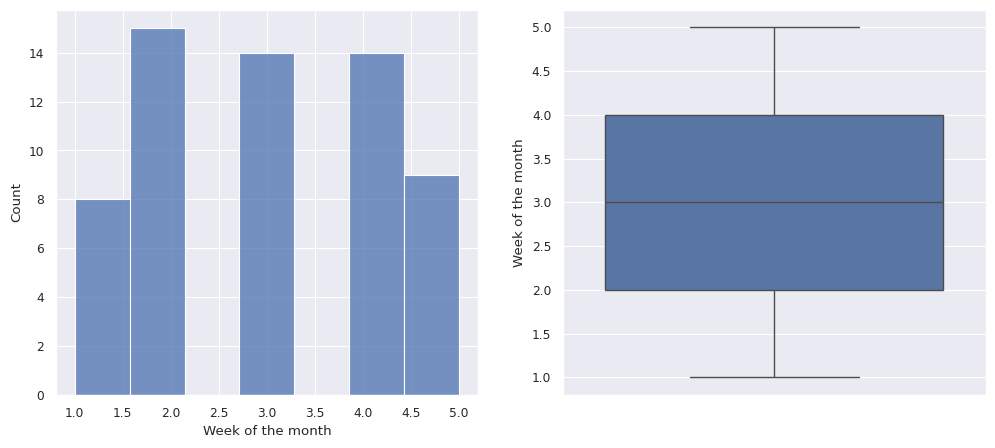

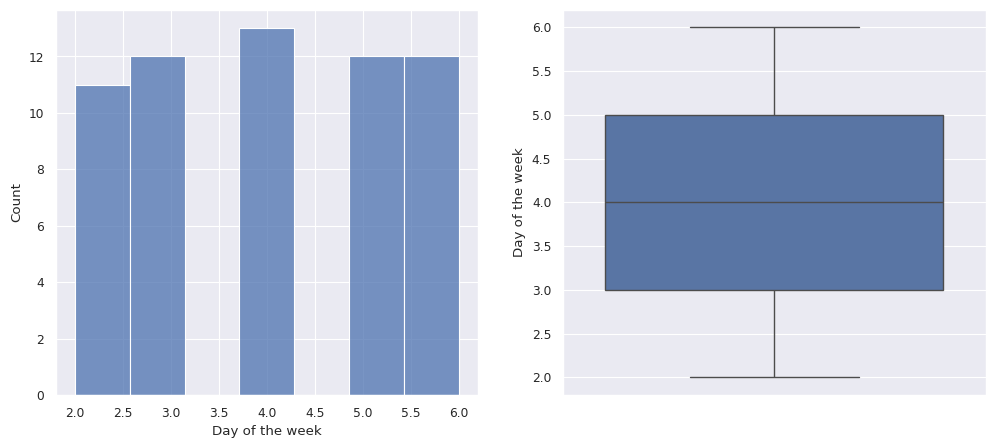

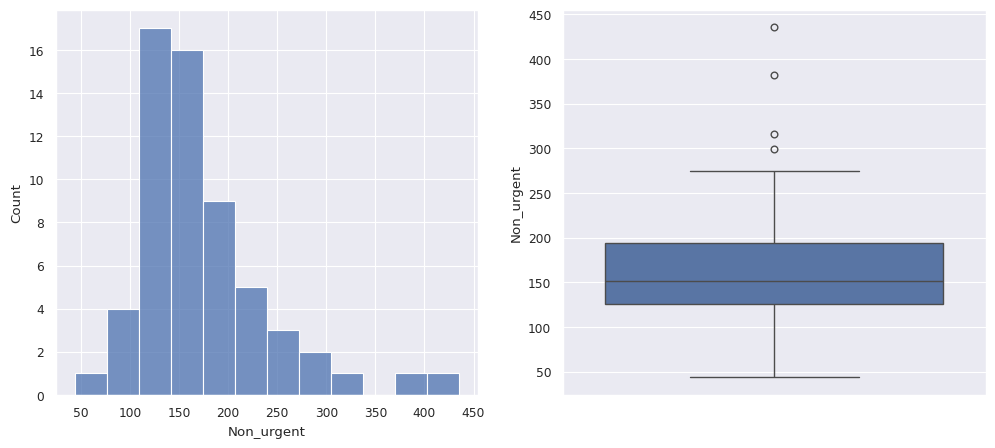

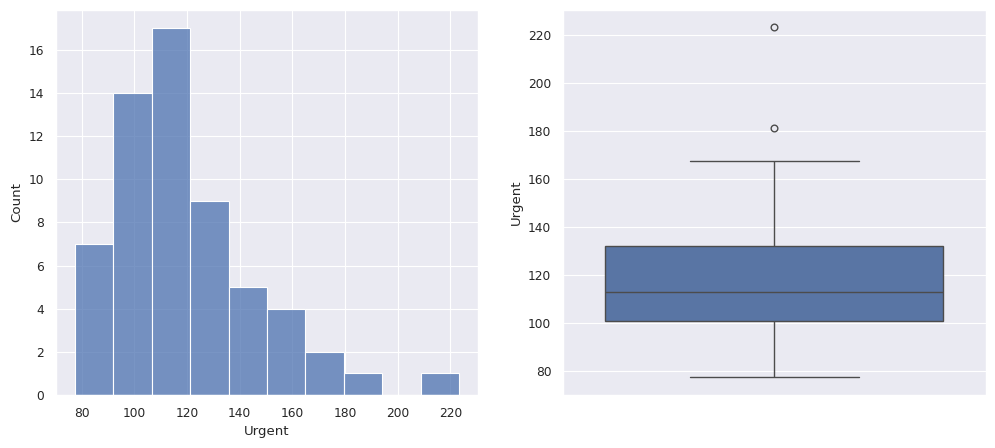

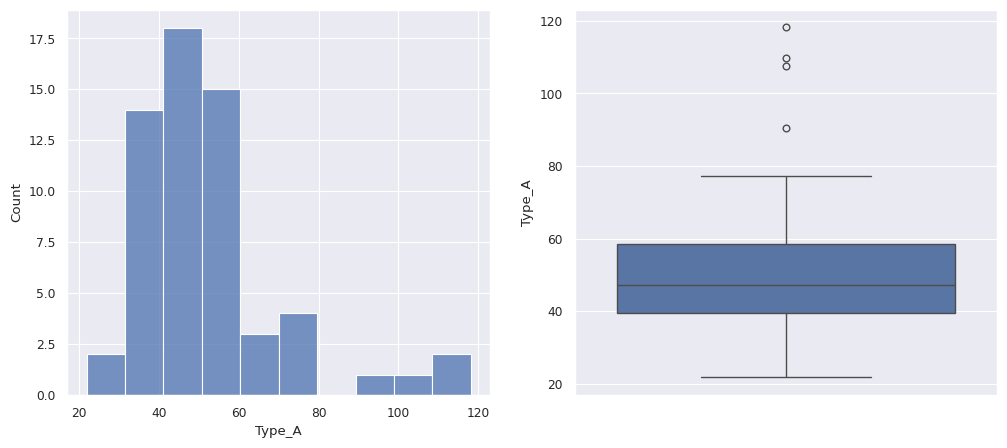

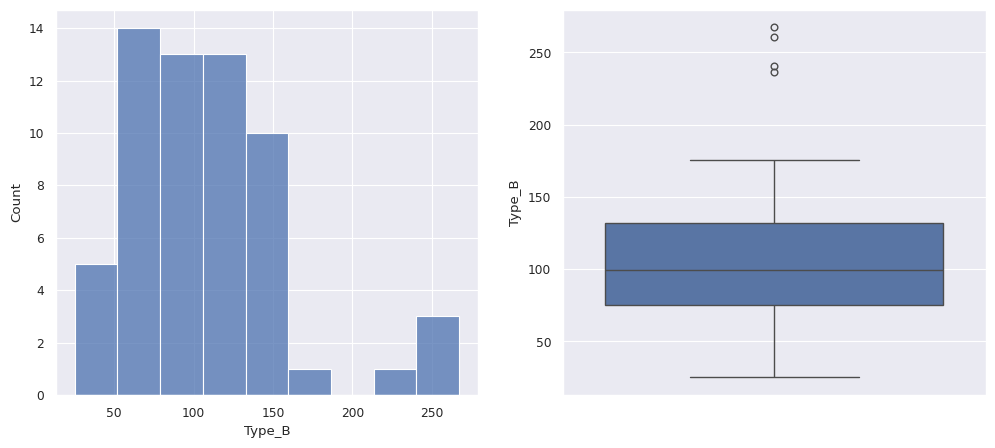

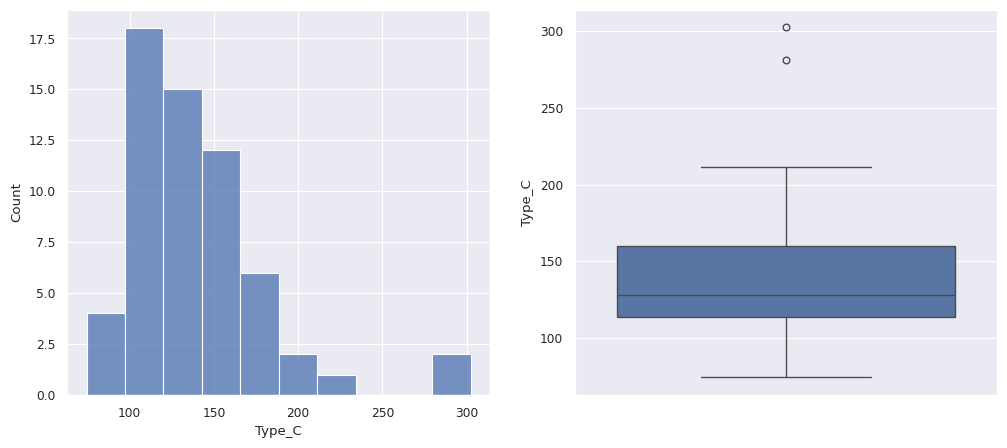

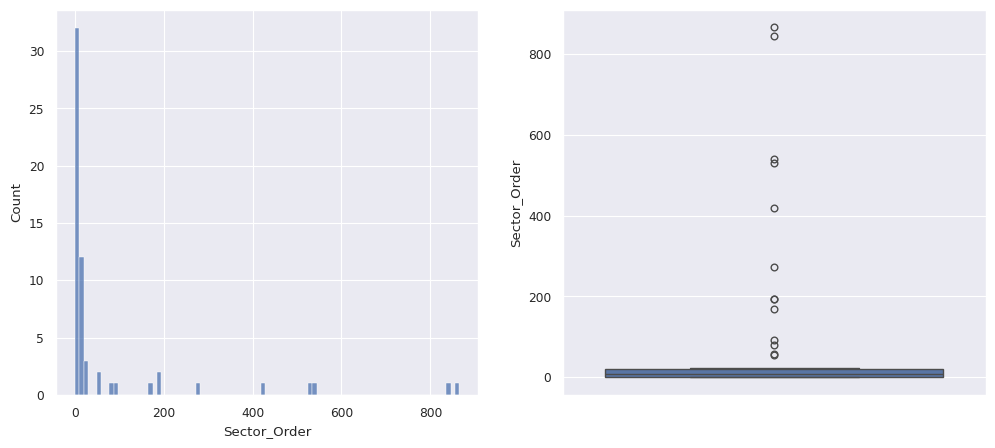

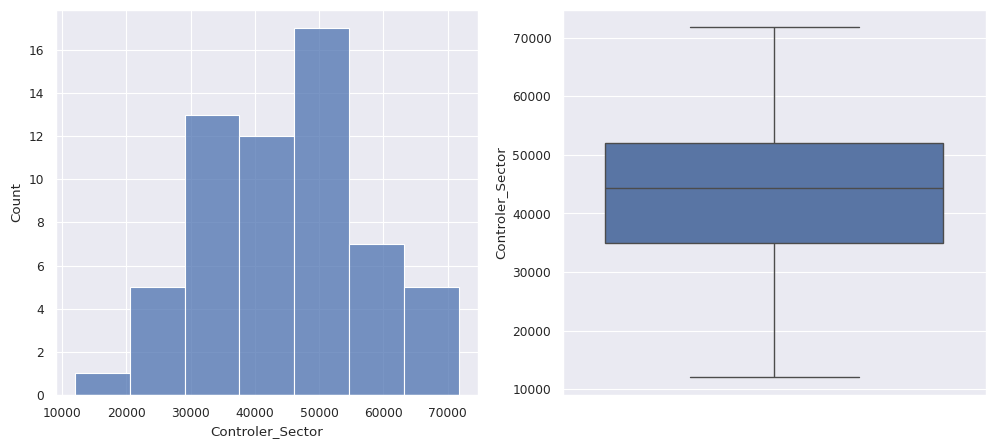

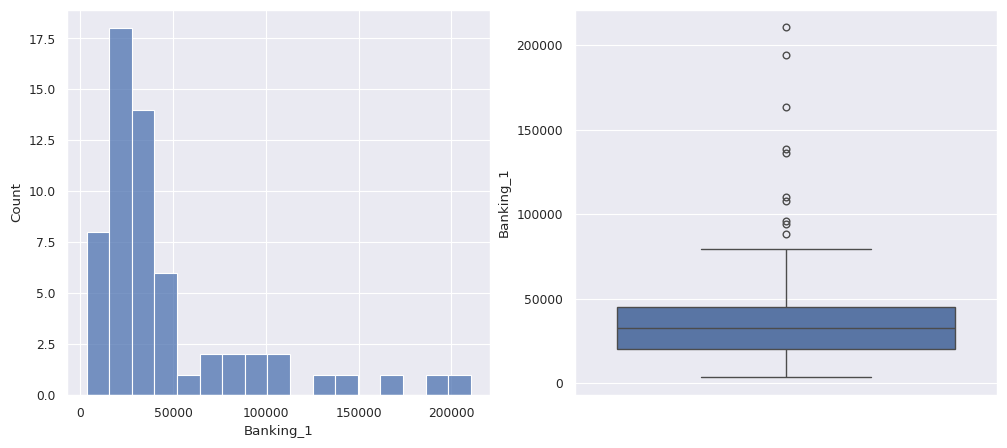

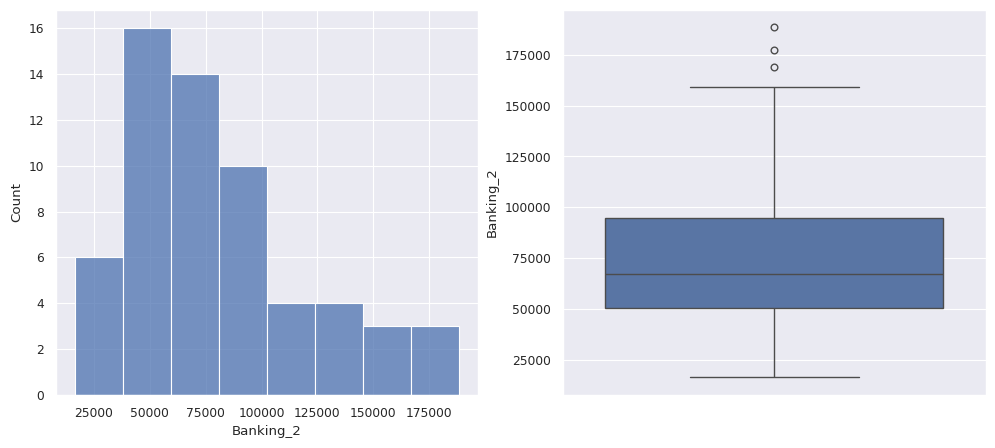

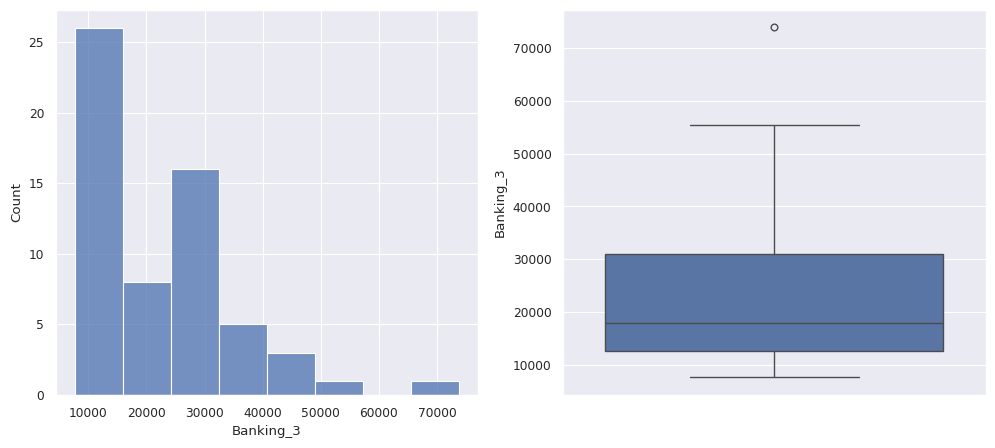

In [106]:
#Se gráfica la distribución de cada variable predictora para realizar el analisis
for col in data_mod.columns:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 5))
  sns.histplot(data=data_mod, x=col, ax=ax[0])
  sns.boxplot(data=data_mod[col], ax=ax[1])
  plt.show()
  plt.close()

#Al visualizar las variables se observa que hay pocos datos atipicos y la distribución no es normal en la *mayoría*

<Axes: >

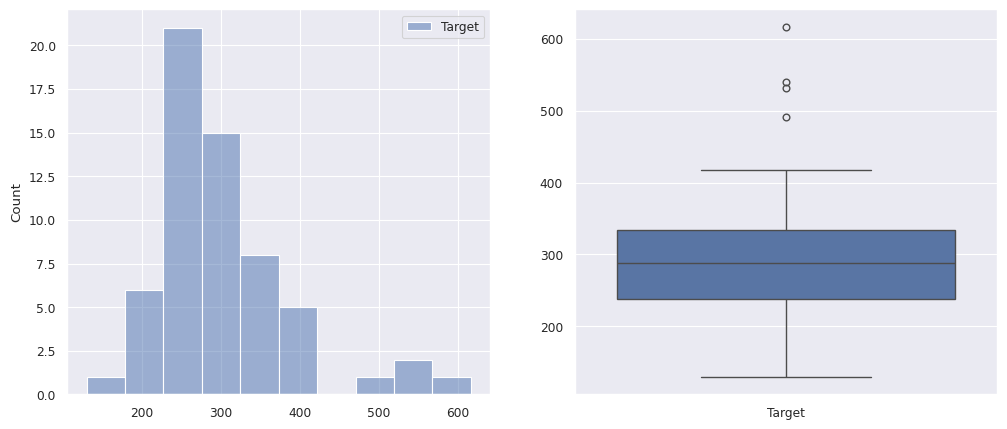

In [107]:
#Se gráfica la distribución de la variable objetivo para realizar el analisis
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(data=y_target, ax=ax[0])
sns.boxplot(data=y_target, ax=ax[1])

#Al visualizar la variable objetivo se observa que hay pocos datos atipicos y la distribución no es normal

## Análisis multivariado

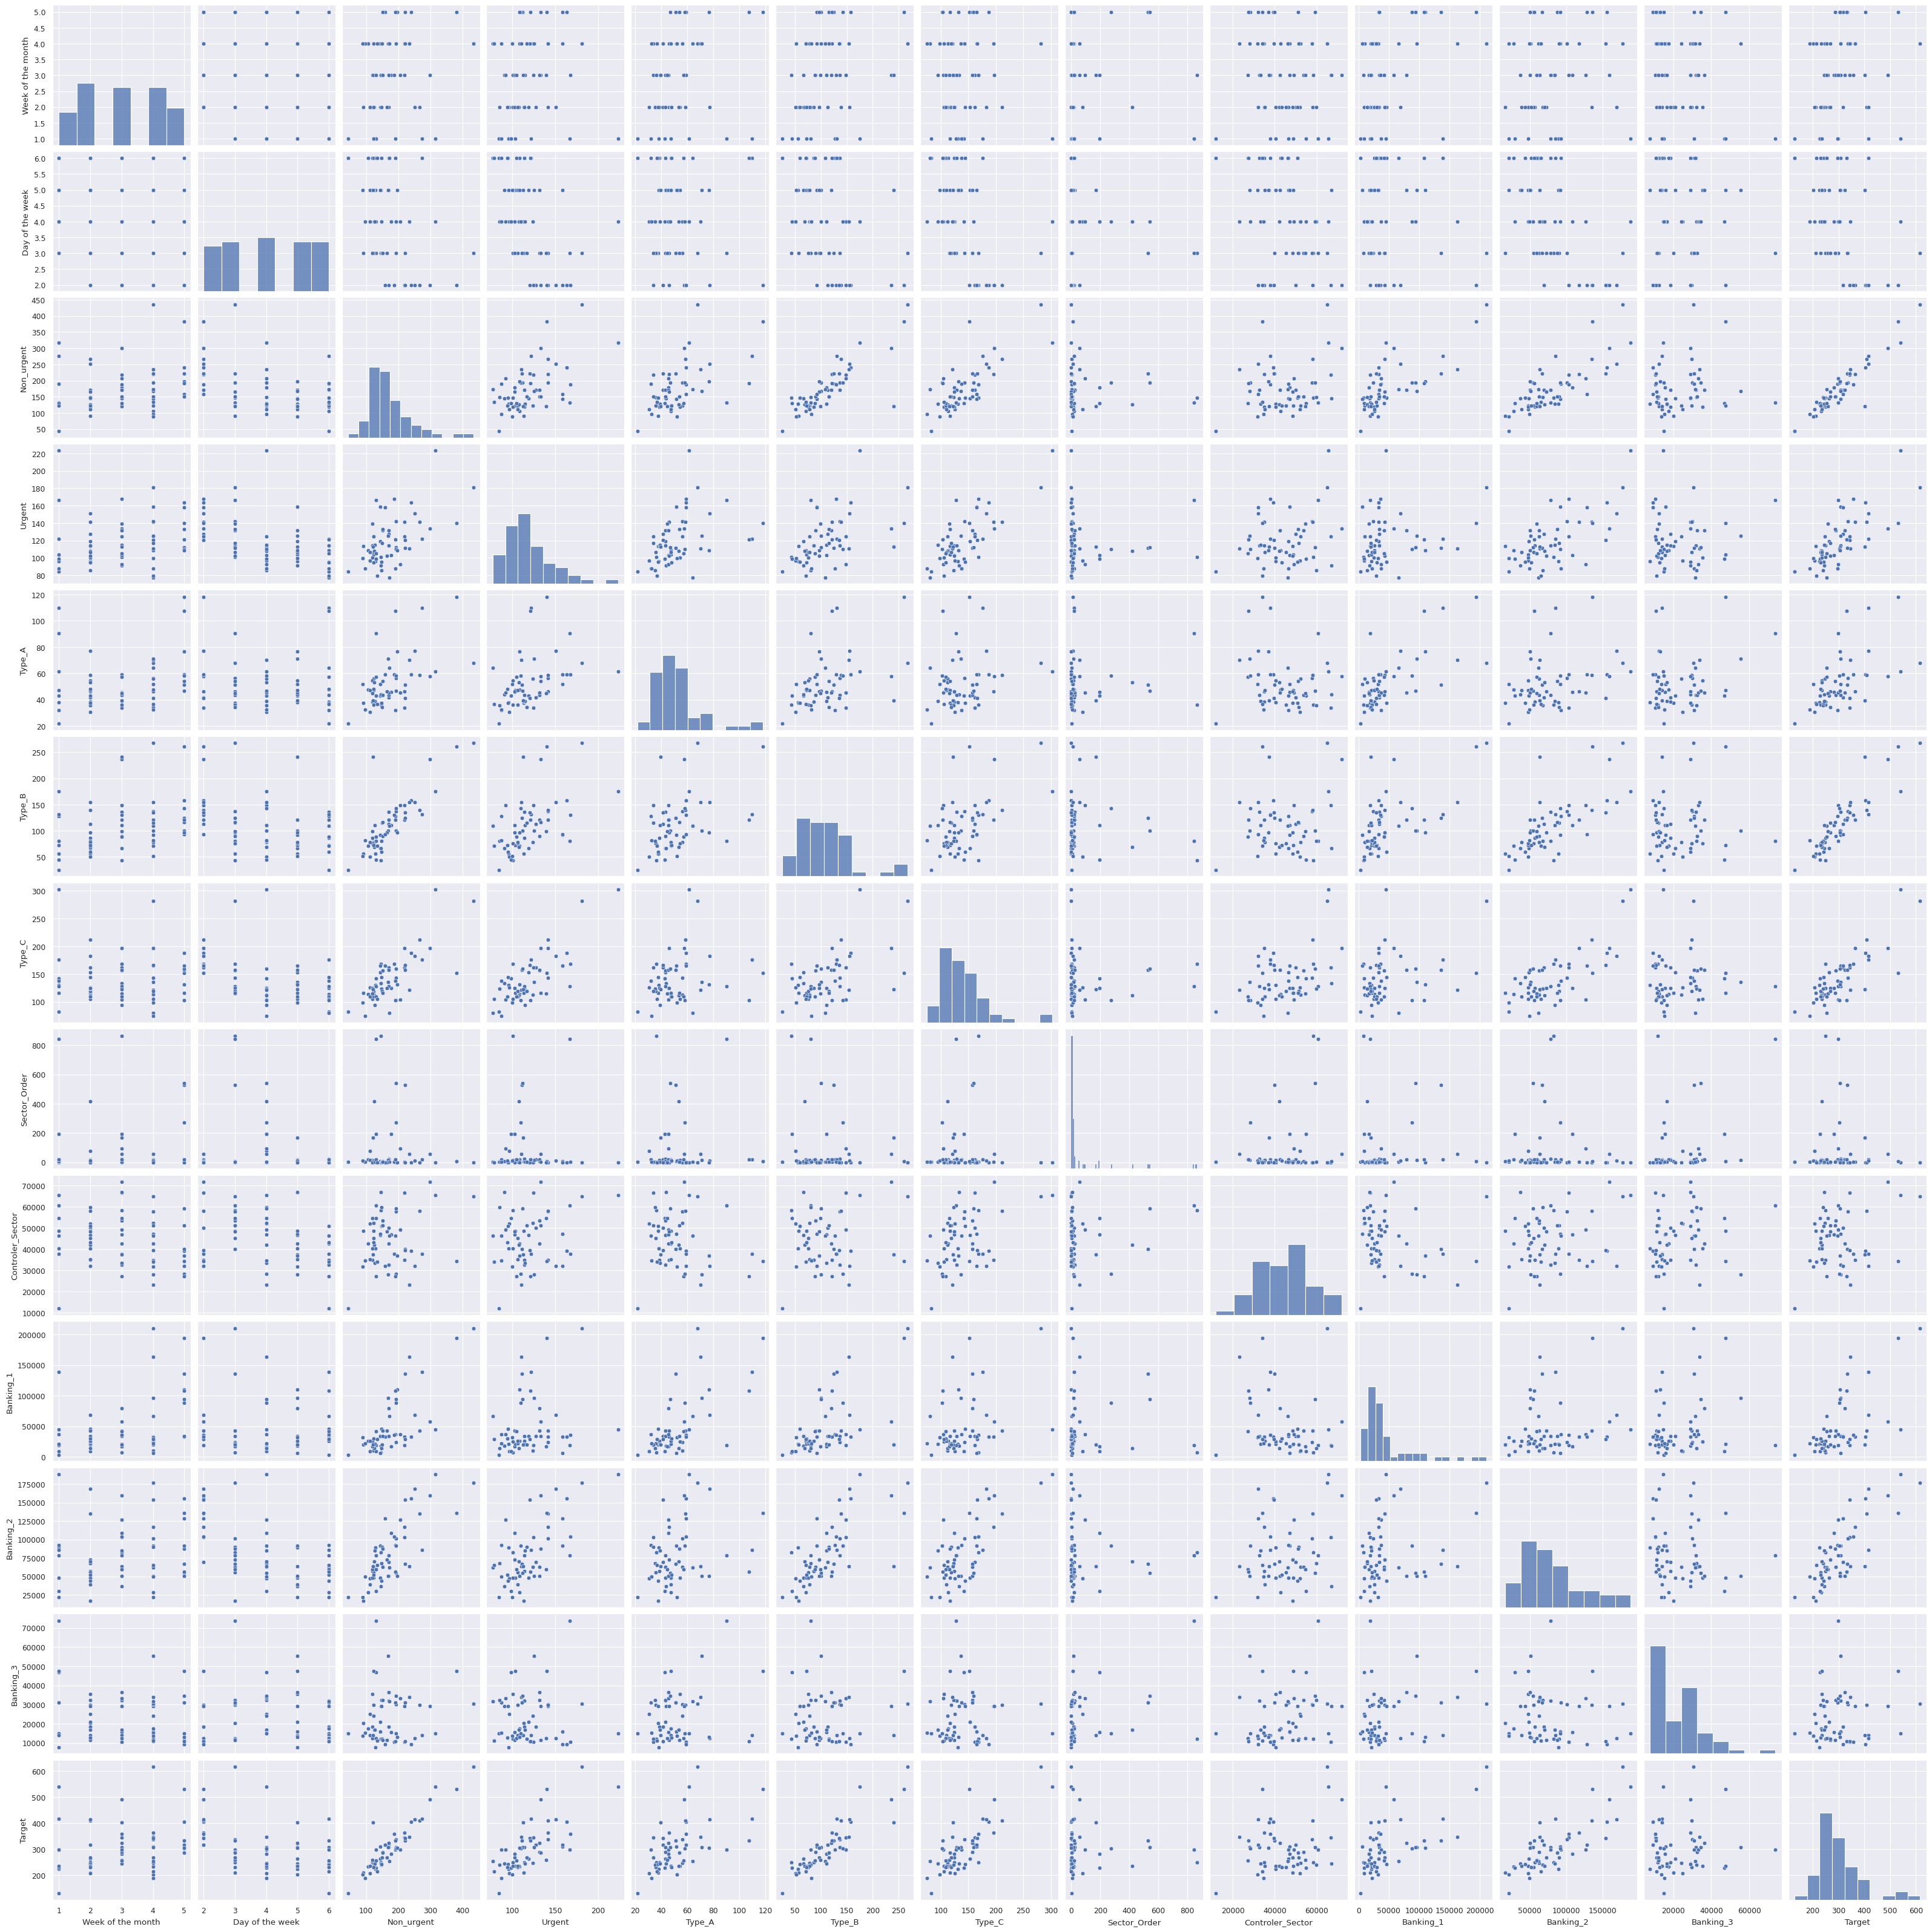

In [108]:
# Se realiza el gráfico de análisis multivariado para observar el comportamiento entre variables
# y obtener una idea de las variables que tienen mas linealidad entre sí
data_pair = data_mod.copy()
data_pair['Target'] = y_target
sns.pairplot(data=data_pair)

### Relación con el target

En la figura anterior se aprecia que con relación a la variable a predecir, las características Non_urgent, Urgent, Type_A, Type_B, Type_C, Banking_1 y Banking_2, razón por la cual se toman como candidatas a variables predictoras en el desarrollo del modelo

In [109]:
data_pair.head(20)

,Week of the month,Day of the week,Non_urgent,Urgent,Type_A,Type_B,Type_C,Sector_Order,Controler_Sector,Banking_1,Banking_2,Banking_3,Target
0,1.0,4.0,316.307,223.270,61.543,175.586,302.448,0.000,65556.0,44914.0,188411.0,14793.0,539.577
1,1.0,5.0,128.633,96.042,38.058,56.037,130.580,0.000,40419.0,21399.0,89461.0,7679.0,224.675
2,1.0,6.0,43.651,84.375,21.826,25.125,82.461,1.386,11992.0,3452.0,21305.0,14947.0,129.412
3,2.0,2.0,171.297,127.667,41.542,113.294,162.284,18.156,49971.0,33703.0,69054.0,18423.0,317.120
4,2.0,3.0,90.532,113.526,37.679,56.618,116.220,6.459,48534.0,19646.0,16411.0,20257.0,210.517
5,2.0,4.0,110.925,96.360,30.792,50.704,125.868,79.000,52042.0,8773.0,47522.0,24966.0,207.364
6,2.0,5.0,144.124,118.919,43.304,66.371,153.368,0.000,46573.0,33597.0,48269.0,20973.0,263.043
7,2.0,6.0,119.379,113.870,38.584,85.961,124.413,15.709,35033.0,26278.0,56665.0,18502.0,248.958
8,3.0,2.0,218.856,124.381,33.973,148.274,162.044,1.054,66612.0,19461.0,103376.0,10458.0,344.291
9,3.0,3.0,146.518,101.045,36.399,43.306,168.723,865.000,58224.0,7742.0,82395.0,11948.0,248.428


<Axes: >

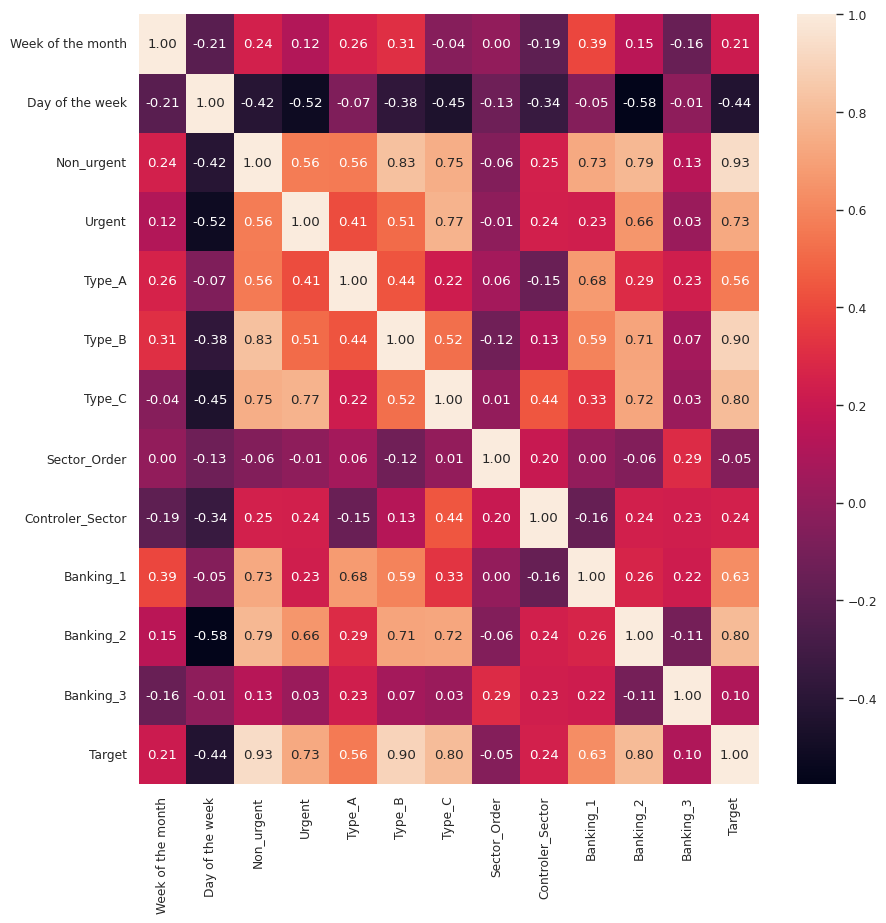

In [110]:
# Se realiza la matriz de correlación en donde se confirma cuales son las variables con mayor linealidad con el target

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=data_pair.corr(method='pearson'), annot=True, fmt='.2f', ax=ax)

# Limpieza de datos

In [111]:
#Se analiza si existen datos duplicados, para este caso no aplica
data_pair.duplicated().sum()

np.int64(0)

In [112]:
data_filtered = clean_corr_var(data=data_pair, threshold=0.9)
data_filtered.describe()

Las columnas eliminadas por tener una correlación superior a 0.9 fueron:
 ['Target']
---------------------------------------------------------------------------------------------
Las columnas eliminadas por varianza cero son:
[]


,Week of the month,Day of the week,Non_urgent,Urgent,Type_A,Type_B,Type_C,Sector_Order,Controler_Sector,Banking_1,Banking_2,Banking_3
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333
std,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000
25%,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000
50%,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000
75%,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000


## Tratamiento de outliers

In [113]:
# Se puede realizar un clipping a los datos con el fin de eliminar los datos atípicos
data_filtered_clp = data_clipping(data=data_filtered.copy(), factor=1.5, ignore=['Week of the month', 'Day of the week'])


# Selección de features para el modelo

Se evaluaron diversas combinaciones de variables predictoras para el desarrollo de los modelos, seleccionadas en función de su correlación y relación lineal con la variable objetivo. El análisis consideró dos enfoques:

    Variables con tratamiento de valores atípicos

    Variables en su estado original sin modificación

La decisión de utilizar las variables sin procesar se basó en:

    La baja presencia de valores atípicos significativos en las variables seleccionadas

    Los resultados comparativos que mostraron que la eliminación de valores atípicos no mejoraba el rendimiento predictivo y, en algunos casos, lo deterioraba

Esta aproximación permitió conservar la integridad de los datos originales mientras se mantenía el desempeño del modelo.

In [114]:
# X = data_filtered_clp[['Type_A', 'Urgent', 'Banking_2']]
# X = data_filtered_clp[['Type_B', 'Non_urgent', 'Banking_2']]
# X = data_filtered_clp[['Type_B', 'Urgent', 'Banking_2']]
# X = data_filtered_clp[['Type_B', 'Non_urgent', 'Banking_1']]
# X = data_filtered_clp[['Type_A', 'Type_B', 'Type_C', 'Non_urgent', 'Urgent']]
# X = data_filtered_clp[['Type_A', 'Non_urgent', 'Urgent']]
# X = data_filtered[['Type_A', 'Urgent', 'Banking_2']]
# X = data_filtered[['Type_B', 'Non_urgent', 'Banking_2']]
# X = data_filtered[['Type_B', 'Urgent', 'Banking_2']]
# X = data_filtered[['Type_B', 'Non_urgent', 'Banking_1']]
# X = data_filtered[['Type_A', 'Non_urgent', 'Urgent']]
X = data_filtered[['Type_A', 'Type_B', 'Type_C', 'Non_urgent', 'Urgent']]
Y = data_pair.Target

# Correlación de variables elegidas

<Axes: >

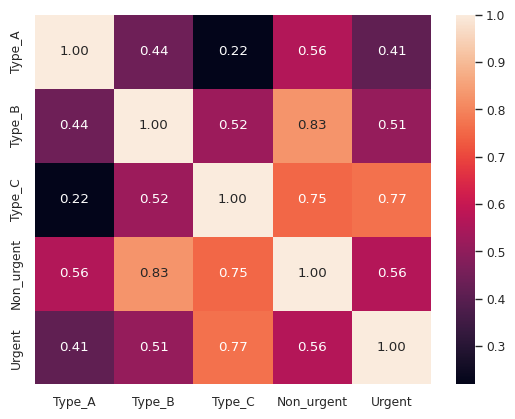

In [115]:
sns.heatmap(data=X.corr(method='pearson'), annot=True, fmt = '.2f')

# Creación de sets de entrenamiento y pruebas

In [116]:
# Se ajusta el tamaño del test a 25% de los datos aplicando la regla general en donde se mantiene
#mayor cantidad de datos para el train que para el test, adicional la decisión se tomo por la baja cantidad de muestras
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, x_test.shape

((45, 5), (15, 5))

## Escalado de los features

In [117]:
# Se utiliza el StandardScaler debido a que la mayoria de variables predictoras presentan una distribución proxima a la normal
# con pocos datos atipicos
scaler = StandardScaler()
scaler_type = 'Standard'

Se escalan los set de entrenamiento y se transforman los de test

In [118]:
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(x_test)

In [119]:
#Imprimir  parámetros
print("scaler.mean_  =", scaler.mean_)   # vector de medias
print("scaler.scale_ =", scaler.scale_)

scaler.mean_  = [ 52.3672     100.46431111 137.14106667 166.69064444 116.30835556]
scaler.scale_ = [17.87748566 45.41122318 36.66441601 65.52173911 23.61432266]


# Modelado regresión lineal y regularización Ridge y Lasso

### Modelo OLS

In [120]:
#Entrenamiento del modelo OLS
init_train=time.time()
ols_model = LinearRegression().fit(X_train, y_train)
stop_train=time.time()
coef_ols = np.concatenate(([ols_model.intercept_], ols_model.coef_))
print("Coeficientes OLS (Solución analítica):\n", coef_ols)
delta_time_train_ols=stop_train-init_train
print("Tiempo de entrenamiento:{:.4f}".format(delta_time_train_ols))

Coeficientes OLS (Solución analítica):
 [1.13686838e-13 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.44328993e-15 1.11022302e-15]
Tiempo de entrenamiento:0.6346


In [121]:
#Validación de valores de entrenamiento
y_pred_train_ols = ols_model.predict(X_train)

rmse_ols = root_mean_squared_error(y_train, y_pred_train_ols)
mae_ols = mean_absolute_error(y_train,y_pred_train_ols)
mape_ols = mean_absolute_percentage_error(y_train,y_pred_train_ols)*100
r2_ols = r2_score(y_train, y_pred_train_ols)
print("OLS - Train: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_ols, r2_ols, mae_ols, mape_ols))

OLS - Train: 
-------------
RMSE = 0.0000
R2 = 1.0000
MAE = 0.0000
MAPE = 0.0000


In [122]:
#Predicción con el set de test
init_train=time.time()
y_pred_test_ols = ols_model.predict(x_test)
stop_train=time.time()
delta_time_test_ols=stop_train-init_train
print("Tiempo de predicción modelo ols con set test: {:.4f}".format(delta_time_test_ols))
# variable del error OLS
err_ols = y_test - y_pred_test_ols
# ----------------------
#Se toma en cuenta el tiempo de predicción para el futuro analisis
rmse_ols = root_mean_squared_error(y_test, y_pred_test_ols)
mae_ols = mean_absolute_error(y_test,y_pred_test_ols)
mape_ols = mean_absolute_percentage_error(y_test,y_pred_test_ols)*100
r2_ols = r2_score(y_test, y_pred_test_ols)
print("OLS - Test: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_ols, r2_ols, mae_ols, mape_ols))

Tiempo de predicción modelo ols con set test: 0.0014
OLS - Test: 
-------------
RMSE = 0.0000
R2 = 1.0000
MAE = 0.0000
MAPE = 0.0000


### Modelo Ridge

In [123]:
# Debido a que parte del rendimiento del modelo Ridge se basa en la selección adecuada de un valor alpha, se realiza una función
# de mapeo para encontrar el mejor para este caso.

alphas = np.logspace(-4, 4, 50)

# Crear el pipeline con estandarización y RidgeCV
ridge_pipeline = make_pipeline(
    scaler,
    RidgeCV(alphas=alphas, store_cv_results=True)
)

# Entrenar el modelo
ridge_pipeline.fit(x_train_scaled, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         store_cv_results=True))])

In [124]:
ridge_model = ridge_pipeline.named_steps['ridgecv']
print("Mejor alpha (Ridge):", ridge_model.alpha_)
print("Coeficientes:", ridge_model.coef_)
print("Intercepto:", ridge_model.intercept_)

# Evaluar en test
init_train=time.time()
y_pred_ridge = ridge_pipeline.predict(x_test_scaled)
stop_train=time.time()
delta_time_test_ridge=stop_train-init_train
err_ridge = y_test - y_pred_ridge

#Se toma en cuenta el tiempo de predicción para el futuro analisis
print("Tiempo de predicción modelo Ridge con set test: {:.4f}".format(delta_time_test_ridge))
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test,y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test,y_pred_ridge)*100
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - Test: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_ridge, r2_ridge, mae_ridge, mape_ridge))



Mejor alpha (Ridge): 0.0001
Coeficientes: [1.78760191e+01 4.54073685e+01 3.66608380e+01 6.04846836e-03
 2.01467283e-03]
Intercepto: 289.97257777777776
Tiempo de predicción modelo Ridge con set test: 0.0018
Ridge - Test: 
-------------
RMSE = 0.0037
R2 = 1.0000
MAE = 0.0017
MAPE = 0.0005


In [125]:
#Coeficientes Estandarizado
coef_ridge= np.concatenate(([ridge_model.intercept_], ridge_model.coef_))
print("Coeficientes Ridge:\n", coef_ridge)

Coeficientes Ridge:
 [2.89972578e+02 1.78760191e+01 4.54073685e+01 3.66608380e+01
 6.04846836e-03 2.01467283e-03]


In [126]:
#Coeficientes No estandarizados

coef_ridge_orig = desnormalize(scaler_type=scaler_type,
                               scaler=scaler,theta=coef_ridge)
print("Coeficientes GD (escala original):", coef_ridge_orig)

Coeficientes GD (escala original): [2.89972578e+02 1.78760191e+01 4.54073685e+01 3.66608380e+01
 6.04846836e-03 2.01467283e-03]


### Modelo Lasso

In [127]:
# Debido a que parte del rendimiento del modelo Lasso se basa en la selección adecuada de un valor alpha, se realiza una función
# de mapeo para encontrar el mejor para este caso.

alphas = np.logspace(-4, 1, 50)
lasso_pipeline = make_pipeline(
    scaler,
    LassoCV(alphas=alphas, cv=5, random_state=42)
)
lasso_pipeline.fit(x_train_scaled, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
                         cv=5, random_state=42))])

In [128]:
lasso_model = lasso_pipeline.named_steps['lassocv']
print("Mejor alpha encontrado:", lasso_model.alpha_)
print("Coeficientes:", lasso_model.coef_)
print("Intercepto:", lasso_model.intercept_)


Mejor alpha encontrado: 0.0001
Coeficientes: [17.92583545 45.53453385 36.78638551 -0.19754828 -0.06792825]
Intercepto: 289.97257777777776


In [129]:
#Coeficientes Estandarizados
coef_lasso= np.concatenate(([lasso_model.intercept_], lasso_model.coef_))
print("Coeficientes Lasso:\n", coef_lasso)

Coeficientes Lasso:
 [ 2.89972578e+02  1.79258355e+01  4.55345338e+01  3.67863855e+01
 -1.97548282e-01 -6.79282460e-02]


In [132]:
#Coeficientes No Estandarizados
coef_lasso_orig = desnormalize(scaler_type,scaler,coef_lasso)
print("Coeficientes Lasso (escala original):", coef_lasso_orig)

Coeficientes Lasso (escala original): [ 2.89972578e+02  1.79258355e+01  4.55345338e+01  3.67863855e+01
 -1.97548282e-01 -6.79282460e-02]


In [133]:
#Se toma en cuenta el tiempo de predicción para el futuro análisis

init_train=time.time()
y_pred_lasso = lasso_pipeline.predict(x_test_scaled)
stop_train=time.time()
delta_time_test_lasso=stop_train-init_train

print("Tiempo de predicción modelo Lasso con set test: {:.4f}".format(delta_time_test_lasso))
# variable del error del modelo lasso
err_lasso = y_test - y_pred_lasso
# ----------------------------------

print("Lasso - Test: \n-------------\n")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R^2:", r2_score(y_test, y_pred_lasso))
mae_ridge = mean_absolute_error(y_test,y_pred_lasso)
mape_ridge = mean_absolute_percentage_error(y_test,y_pred_lasso)*100
print("MAE:", mae_ridge)
print("MAPE:", mape_ridge)


Tiempo de predicción modelo Lasso con set test: 0.0014
Lasso - Test: 
-------------

MSE: 0.014268084417872778
R^2: 0.9999985407057421
MAE: 0.05598101210428771
MAPE: 0.015595588358059383


# SVR

In [142]:
# Se evaluan los diferentes kernels con diferentes valor de C para obtener el mejor para este caso
C = [.1,1,10,100,1000, 10000];
K = ['linear','poly','rbf','sigmoid']
f = make_subplots(1,4,subplot_titles=K)
for i,k in enumerate(K,1):
    r = [((m:=SVR(kernel=k,C=c).fit(X_train,y_train)).score(X_train,y_train), m.score(x_test,y_test)) for c in C]
    f.add_trace(go.Scatter(x=C,y=[t for t,_ in r],mode='lines',name='train_'+k),1,i)
    f.add_trace(go.Scatter(x=C,y=[u for _,u in r],mode='lines',name='test_'+k),1,i)
f.update_xaxes(type='log',title='C')
f.update_yaxes(title='$R^2$')
f.show()

In [143]:
#Se selecciona el kernel lineal debido a que obtuvo el mejor comportamiento con un valor de C
#Entrenamiento del modelo
svr_model = SVR(C = 10, kernel = 'linear')
svr_model.fit(X_train,y_train)

SVR(C=10, kernel='linear')

Evaluación del modelo SVR con respecto al set de entrenamiento

In [144]:
y_pred_train_svr = svr_model.predict(X_train)

rmse_svr = root_mean_squared_error(y_train, y_pred_train_svr)
mae_svr = mean_absolute_error(y_train,y_pred_train_svr)
r2_svr = r2_score(y_train, y_pred_train_svr)
mape_svr = mean_absolute_percentage_error(y_train, y_pred_train_svr)*100
print("SVR - Train: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_svr, r2_svr, mae_svr, mape_svr))

SVR - Train: 
-------------
RMSE = 0.0549
R2 = 1.0000
MAE = 0.0454
MAPE = 0.0159


Evaluación del modelo SVR con respecto al set de prueba

In [145]:
init_train=time.time()
y_pred_test_svr = svr_model.predict(x_test)
stop_train=time.time()
delta_time_test_svr=stop_train-init_train

print("Tiempo de predicción modelo SVR con set test: {:.4f}".format(delta_time_test_svr))
# variable del error del SVR
err_svr = y_test - y_pred_test_svr
# ----------------------------------

rmse_svr = root_mean_squared_error(y_test, y_pred_test_svr)
mae_svr = mean_absolute_error(y_test,y_pred_test_svr)
r2_svr = r2_score(y_test, y_pred_test_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_test_svr)*100
print("SVR - Test: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_svr, r2_svr, mae_svr, mape_svr))

Tiempo de predicción modelo SVR con set test: 0.0027
SVR - Test: 
-------------
RMSE = 0.1307
R2 = 1.0000
MAE = 0.0791
MAPE = 0.0227


# Arbol de decisión

In [146]:
# Crear y entrenar el modelo de árbol de decisión
decision_tree_model = DecisionTreeRegressor(criterion='squared_error',
                                            splitter='best',max_depth=6,random_state=42)
decision_tree_model.fit(X_train, y_train)

# Mostrar la profundidad del árbol y el número de hojas
print(f"Profundidad del árbol: {decision_tree_model.get_depth()}")
print(f"Número de hojas: {decision_tree_model.get_n_leaves()}")

Profundidad del árbol: 6
Número de hojas: 27


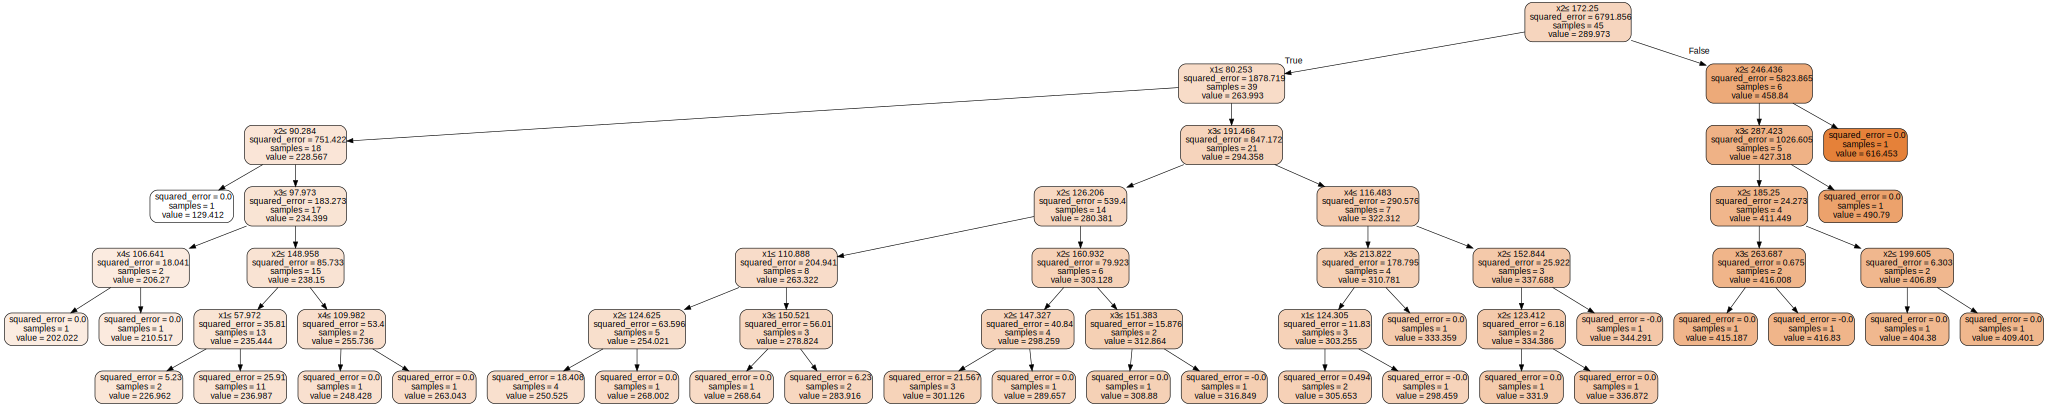

In [147]:
#Gráficar arbol
dot_data = export_graphviz(decision_tree_model, out_file = "arbol.dot", filled=True, rounded=True, special_characters=True)
with open("arbol.dot") as f:
  dot_data = f.read()
display(graphviz.Source(dot_data))

In [148]:
#Se toma en cuenta el tiempo de predicción para el futuro análisis
#Predicción con el set de test

init_train=time.time()
y_pred_test_dt = decision_tree_model.predict(x_test)
stop_train=time.time()
delta_time_test_dt=stop_train-init_train

print("Tiempo de predicción modelo DT con set test: {:.4f}".format(delta_time_test_dt))
# variable de error del árbol de dicisión
err_dt = y_test - y_pred_test_dt
# ----------------------------------

rmse_dt = root_mean_squared_error(y_test, y_pred_test_dt)
mae_dt = mean_absolute_error(y_test,y_pred_test_dt)
r2_dt = r2_score(y_test, y_pred_test_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_test_dt)*100
print("decision_tree_model - Test: \n-------------\nRMSE = {:.4f}\nR2 = {:.4f}\nMAE = {:.4f}\nMAPE = {:.4f}".format(rmse_dt, r2_dt, mae_dt, mape_dt))

Tiempo de predicción modelo DT con set test: 0.0072
decision_tree_model - Test: 
-------------
RMSE = 68.8383
R2 = 0.5153
MAE = 44.0517
MAPE = 12.1335


# Impresión de los errores

In [151]:
min_val = min(y_test.min(), y_pred_test_ols.min())
max_val = max(y_test.max(), y_pred_test_ols.max())

fig = go.Figure(data=[
    go.Scatter(x=y_test, y=y_pred_test_ols, mode='markers', name='OLS',
               marker=dict(color='blue', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_lasso, mode='markers', name='Lasso',
               marker=dict(color='cyan', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_ridge, mode='markers', name='Ridge',
               marker=dict(color='gold', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_dt, mode='markers', name='DT',
               marker=dict(color='#f20d0d', opacity=0.6)),
    go.Scatter(x=y_test, y=y_pred_test_svr, mode='markers', name='SVR',
               marker=dict(color='green', opacity=0.6)),
    go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines',
               name='Ideal', line=dict(color='black', dash='dash'))
])
fig.update_yaxes(range=[min_val*-0.15, max_val*1.2])
fig.update_xaxes(range=[min_val*-0.15, max_val*1.1])
fig.update_layout(title="Rendimiento: Test",
                  xaxis_title="Ventas (Real Data)",
                  yaxis_title="Ventas (Predicted)")
fig.show()

In [152]:
fig_err = go.Figure(data=[go.Histogram(x=err_ols, name='OLS'),
                          go.Histogram(x=err_ridge, name='Ridge'),
                          go.Histogram(x=err_lasso, name='Lasso'),
                          go.Histogram(x=err_svr, name='SVR'),
                          go.Histogram(x=err_dt, name='DT')])
fig_err.update_layout(title="Ridge: Errors behavior",
                  xaxis_title="Error de pronóstico")
fig_err.show()

In [153]:
#Se toma en cuenta el tiempo de predicción de todos los modelos
data_time={
    'delta_test_ols':delta_time_test_ols,
    'delta_test_ridge':delta_time_test_ridge,
    'delta_test_lasso':delta_time_test_lasso,
    'delta_test_svr':delta_time_test_svr,
    'delta_test_dt':delta_time_test_dt
}
data_time=pd.DataFrame(data_time, index=[0])
data_time.head()

,delta_test_ols,delta_test_ridge,delta_test_lasso,delta_test_svr,delta_test_dt
0,0.001432,0.001823,0.001383,0.002698,0.007152


<Axes: >

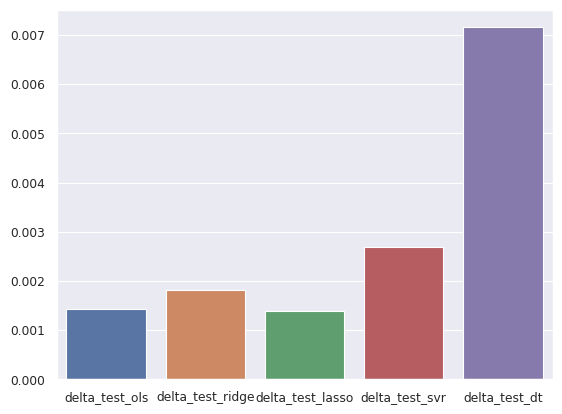

In [154]:
sns.barplot(data=data_time)

In [155]:
#Importación del modelo
# import pickle
# with open('model_admit.pkl', 'wb') as f:
#     pickle.dump(lasso_model, f)
# print("Modelo guardado en model_insurance.pkl")

| Variables                           | Métrica |No filtrados |        |          |       |      | Filtrados |        |          |       |      |
|:-------------------------------------:|---------|:--------------:|:--------:|:----------:|:-------:|:------:|:-----------:|:--------:|:----------:|:-------:|:------:|
|                                     |         | OLS          | RIDGE  | LASSO    | SVR   | DT   | OLS       | RIDGE  | LASSO    | SVR   | DT   |
| **Type_B Non_urgent Banking_1**     | RMSE    | 38,01        | 37,96  | 1481,02  | 96,27 | 68,22| 35,03     | 35,79  | 1239,07  | 103,90| 58,20|
|                                     | R2      | 0,85         | 0,85   | 0,84     | 0,05  | 0,52 | 0,87      | 0,86   | 0,87     | -0,10 | 0,65 |
|                                     | MAE     | 29,56        | 29,52  | 29,93    | 72,86 | 51,92| 28,19     | 28,54  | 28,30    | 78,64 | 42,75|
|                                     | MAPE    | 8,71%        | 8,71%  | 8,82%    | 20,22%|14,58%| 8,33%     | 8,44%  | 8,33%    |21,42% |12,50%|
| **Type_B Urgent Banking_2**         | RMSE    | 32,07        | 31,94  | 1030,71  | 78,12 | 77,70| 36,86     | 35,81  | 1362,64  | 78,28 | 76,79|
|                                     | R2      | 0,89         | 0,89   | 0,89     | 0,37  | 0,38 | 0,86      | 0,86   | 0,86     | 0,37  | 0,39 |
|                                     | MAE     | 23,56        | 23,45  | 23,50    | 64,38 | 62,91| 30,62     | 29,47  | 30,35    | 64,59 | 62,14|
|                                     | MAPE    | 7,61%        | 7,58%  | 7,60%    |18,53% |19,96%| 9,43%     | 9,04%  | 9,30%    |18,59% |19,83%|
| **Type_B Non_urgent Banking_2**     | RMSE    | 39,50        | 38,97  | 1560,66  | 50,93 | 56,78| 35,80     | 35,88  | 1282,32  | 76,57 | 56,78|
|                                     | R2      | 0,84         | 0,84   | 0,84     | 0,61  | 0,67 | 0,86      | 0,86   | 0,86     | 0,40  | 0,67 |
|                                     | MAE     | 30,06        | 29,81  | 30,06    | 33,34 | 42,43| 29,00     | 29,34  | 29,00    | 64,13 | 42,43|
|                                     | MAPE    | 8,98%        | 8,92%  | 8,98%    |11,22% |12,67%| 8,53%     | 8,66%  | 8,53%    |19,16% |12,67%|
| **Type_A Urgent Banking_2**         | RMSE    | 50,92        | 50,78  | 2593,06  | 78,12 | 76,98| 57,11     | 57,65  | 3262,04  | 76,58 | 73,82|
|                                     | R2      | 0,73         | 0,73   | 0,73     | 0,37  | 0,39 | 0,66      | 0,66   | 0,66     | 0,40  | 0,44 |
|                                     | MAE     | 36,71        | 36,87  | 36,71    | 64,38 | 62,64| 42,22     | 42,65  | 42,22    | 64,13 | 57,81|
|                                     | MAPE    |10,61%        |10,65%  |10,61%    |18,53% |18,77%|11,50%     |11,62%  |11,50%    |19,16% |17,01%|
| **Type_A Non_urgent Urgent**        | RMSE    | 43,58        | 43,47  | 1877,85  | 46,22 | 63,34| 47,32     | 47,32  | 2241,73  | 47,85 | 60,47|
|                                     | R2      | 0,80         | 0,80   | 0,80     | 0,78  | 0,58 | 0,77      | 0,77   | 0,77     | 0,76  | 0,62 |
|                                     | MAE     | 18,06        | 17,84  | 17,90    | 22,55 | 44,40| 25,48     | 25,48  | 25,43    | 23,85 | 42,75|
|                                     | MAPE    | 4,96%        | 4,93%  | 5,00%    |5,83%  |11,99%| 6,63%     | 6,63%  | 6,58%    |6,28%  |11,69%|
| **Type_A Type_B Type_C Non_urgent Urgent** | RMSE | 0      | 0,0037 | 0,014    | 0,13  | 76,57| 28,17     | 23,5   | 372,43   | 27,19 | 76,57|
|                                     | R2      | 1           | 1      | 0,99     | 1     | 0,4  | 0,91      | 0,94   | 0,96     | 0,92  | 0,4  |
|                                     | MAE     | 0           |0,0017  | 0,05     | 0,07  |50,49 | 18,41     |16,26   |13,04     |11,26  |50,49 |
|                                     | MAPE    |0,00%        |0,05%   |1,00%     |2,00%  |13,86%|4,83%      |4,26%   |3,41%     |2,21%  |13,86%|

Luego de realizar las diferentes combinaciones de variables predictoras y a partir de la comparativa de tiempo de ejecución, se decide implementar el modelo de predicción _Lasso_, ya que presenta junto con el modelo _Ridge_ las mejores métricas. Adicional se toma la decisión teniendo en cuenta el tiempo de predicción.